# Quantum energy teleportation protocol to storage energy
https://doi.org/10.1103/PhysRevLett.130.110801

### Import packages

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator

## Model

### Theory

In [ ]:
# Parameters
h_A = 1; h_B = 1; k = 1;
h_C = np.sqrt(h_B**2 + 4*k**2) 

# Define basis
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)

# Define base operators
I = Operator.from_label('III').to_matrix()
Z_A = Operator.from_label('IIZ').to_matrix(); Z_B = Operator.from_label('IZI').to_matrix(); Z_C = Operator.from_label('ZII').to_matrix()
X_AB = Operator.from_label('IXX').to_matrix(); X_A = Operator.from_label('IIX').to_matrix()
Y_B = Operator.from_label('IYI').to_matrix(); Y_C = Operator.from_label('YII').to_matrix()

# Ground state
theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))

qet_g = np.cos(theta)*ket_00 - np.sin(theta)*ket_11
ket_g = np.kron(ket_0,qet_g)
state_g = Statevector(ket_g)

# Hamiltonians
f = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)

H_A = -h_A * Z_A - h_A*(f**2-1)/(f**2+1) * I
H_B = -h_B * Z_B - h_B*(f**2-1)/(f**2+1) * I
H_C = -h_C * Z_C + h_C * I
V = 2*k * X_AB + 4*k*f/(f**2+1) * I

# Define angle phi
delta = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

# Define operations
def P_A(mi):
    """Measurement of qubit A"""
    return 1/2 * (I + mi * X_A)

def Ry_B(mi):
    """Rotation around Y axis for qubit B"""
    return np.cos(delta) * I - 1j*mi*np.sin(delta) * Y_B

def Ry_C(mi):
    """Rotation around Y axis for qubit C"""
    return np.cos(delta) * I - 1j*mi*np.sin(delta) * Y_C

def Ry_pi():
    """Rotation of pi around Y axis for qubit C"""
    return np.cos(np.pi/2) * I - 1j*np.sin(np.pi/2) * Y_C

# Final State Density Matrix
P_QET = np.zeros((8, 8), dtype=complex)
for mi in [-1, 1]:
    P_QET = Ry_C(-mi) @ Ry_B(-mi) @  Ry_C(mi) @ Ry_pi() @P_A(mi) @ (ket_g@ket_g.conj().T) @ P_A(mi) @ Ry_pi().conj().T @ Ry_C(mi).conj().T  @ Ry_B(-mi).conj().T @ Ry_C(-mi).conj().T + P_QET

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_Hc = np.trace(P_QET@H_C).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real 

# Showresults
display('Ground State:', Operator(state_g).draw('latex'))
display('Final State Density Matrix:', Operator(P_QET).draw('latex'))

print(f"""
Ground State Energies:
<H_A> = {(ket_g.T@H_A@ket_g)[0][0].real},
<H_B> = {(ket_g.T@H_B@ket_g)[0][0].real},
<V>   = {(ket_g.T@V@ket_g)[0][0].real}.
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
H_C = {E_Hc},
V   = {E_V},
E_A = {E_A},
E_B = {E_B}.
""")


'Ground State:'

<IPython.core.display.Latex object>

'Final State Density Matrix:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = 5.551115123125783e-17
<H_B> = 5.551115123125783e-17
<V> = -1.1102230246251565e-16
            
Final Energies:
H_A = 0.7071067811865476,
H_B = 0.2598931856865897,
H_C = 4.47213595499958,
V = -0.3746408196267367,
E_A = 0.3324659615598108,
E_B = -0.11474763394014692



### Create circuit

In [6]:
def qet(h_A,h_B,k):
    qc = QuantumCircuit(3,3, metadata={'h_A':h_A, 'h_B':h_B, 'k':k})

    # Prepare ground state
    alpha = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))

    qc.ry(-2*alpha,0)
    qc.cx(0,1)

    qc.barrier()    
    # Alice's projective measurement
    qc.h(0)

    qc.barrier()
    # Charlie prepare qubit C
    delta = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

    qc.cry(np.pi - 2*delta,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*delta,0,2)
    qc.x(0)

    qc.barrier()
    # Conditional operation
    qc.cry(2*delta,0,1)
    qc.cry(2*delta,0,2)
    
    qc.x(0)
    qc.cry(-2*delta,0,1)
    qc.cry(-2*delta,0,2)
    qc.x(0)

    qc.barrier()
    return qc

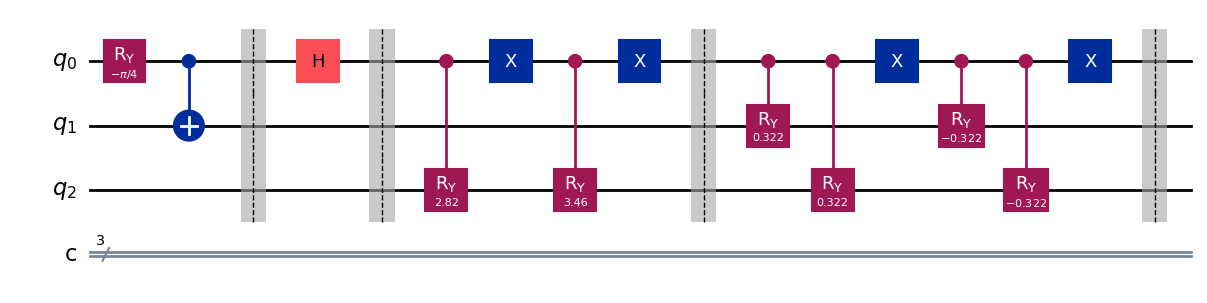

In [7]:
# Show circuit
qet(1,1,1).draw('mpl')

## Simulate circuit

### Run simulation

In [ ]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1; h_B = 1; k = 1;
h_C = np.sqrt(h_B**2 + 4*k**2)
n_shots = 100000

# Generate circuits
qc = qet(h_A, h_B, k)
qc_H.measure_all(add_bits=False)

qc = qet(h_A, h_B, k)
qc_V.h(1)
qc_V.measure_all(add_bits=False)

# Run job 
sim_H = simulator.run(qc_H, shots=n_shots)
sim_V = simulator.run(qc_V, shots=n_shots)

### Show Results for simulated circuit $H$

H_A =  0.7085067811865475 ± 0.0031622745611347533
H_B =  0.2616667811865475 ± 0.002831224481386101
H_C =  4.472135954999579 ± 1.4043333874306802e-18


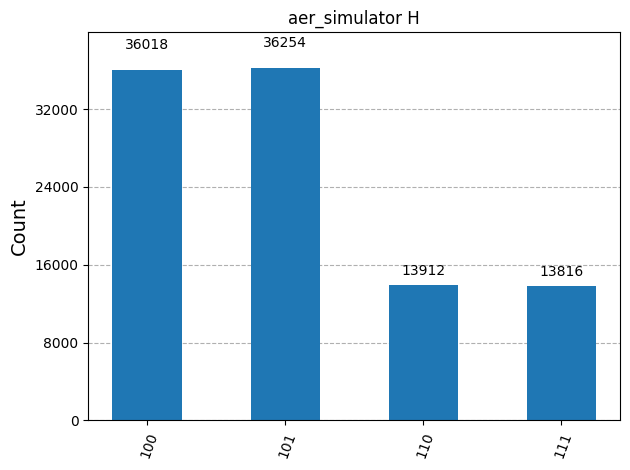

In [ ]:
# Extract results
result = sim_H.result()
counts = result.get_counts()

# Energies
f = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B) 

ene_A = -h_A * (f**2-1)/(f**2+1)
ene_B = -h_B * (f**2-1)/(f**2+1)
ene_C = h_C

# Error arrays
error_A = []
error_B = []
error_C = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots      
        ene_C += -h_C*(-1)**int(bit_string[2])*count/n_shots
        for i in range(count):
            error_A.append(-h_A*(-1)**int(bit_string[0]))
            error_B.append(-h_B*(-1)**int(bit_string[1]))
            error_C.append(-h_C*(-1)**int(bit_string[2]))

# Show results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"H_C = {ene_C} ± {np.std(error_C)/np.sqrt(n_shots)}")
plot_histogram(counts, title="aer_simulator H")

### Show results for simulated circuit $V$

V =  -0.3783464376269049 ± 0.006324555288713981


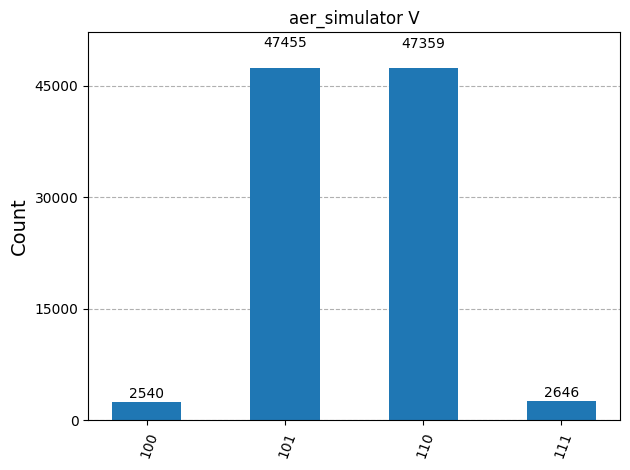

In [ ]:
# Extract results
result = sim_V.result()
counts = result.get_counts()

# Energy
f = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)

ene_V = 4*k*f/(f**2+1)

# Error array
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Show results
print(f"V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
plot_histogram(counts, title="Simulated V")

## Run circuit on hardware

### Import IBM packages

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, 
                                Batch, 
                                SamplerV2 as sampler, 
                                EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

### Get backend

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()
print(backend.name)

ibm_torino


### Run job with Sampler

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]
n_shots = 3000

# Run job in Batch mode
with Batch(backend=backend):

    # initiate sampler and configure error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True
    options.twirling.enable_measure= True

    for variable in variables:
        h_A = variable[0]
        h_B = h_A
        k = variable[1]

        # Generate circuits H and V
        circuit_H = qet(h_A, h_B, k)
        circuit_H.measure_all(add_bits=False)
        transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qet(h_A, h_B, k)
        circuit_V.h(1)
        circuit_V.measure_all(add_bits=False)
        transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)
        
        # Run job
        job_A = sampler.run([(transpiled_H), (transpiled_V)], shots=n_shots)
        job_A.update_tags([f'k={k},h_(A/B)={h_A}','error mitigated','sampler','ES',f'{n_shots}'])  # Add tags to job
        print(f"Sampler, ID = {job_A.job_id()}, h_(A/B) = {h_A} k = {k}")

### Run circuit with Estimator

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]

# Configure the transpiler
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

# Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h_A = variable[0]
        h_B = h_A
        k = variable[1]
        observables = [SparsePauliOp('IZI', -h_B), SparsePauliOp('ZII', -h_C),SparsePauliOp('IXX', 2*k)]

        # Generate circuit
        circuit_T = qet(h_A, h_B, k)
        circuit_T.h(0)
        transpiled_T = transpiler.run(circuit_T)
    
        # Run job
        transpiled_observables = [observable.apply_layout(transpiled_T.layout) for observable in observables]
        job_B = estimator(options={'resilience_level':2}).run([(transpiled_T, transpiled_observables)]) # transpiled_observables[0] [1] or [2] to run separately
        job_B.update_tags([f'k={k},h_(A/B) = {h_A}','error mitigated','estimator','ES']) # Add tags 
        print(f"Estimator, ID = {job_B.job_id()}, h_(A/B) = {h_A} k = {k}")  

Estimator V, ID = d3mrje1fk6qs73e89brg, h_(A/B) = 1 k = 1


### Results

### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job('') 
result = jobS.result()[0]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value_B = result.data.evs[0]
value_error_B = result.data.stds[0]
exp_value_C = result.data.evs[1]
value_error_C = result.data.stds[1]

# Parameters
metadata = result.metadata.get('circuit_metadata')
k = metadata.get('k')
h_A = metadata.get('h_A')
h_B = metadata.get('h_B')
h_C = np.sqrt(h_B**2 + 4*k**2) 

# Energies
f = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B) 

ene_A = -h_A * (f**2-1)/(f**2+1)
ene_B = -h_B * (f**2-1)/(f**2+1)
ene_C = h_C

est_B = exp_value_B + ene_B
est_C = exp_value_C + ene_C

# Error arrays
error_B = []
error_C = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]   # Invert bits ordering
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots      
        ene_C += -h_C*(-1)**int(bit_string[2])*count/n_shots
        for i in range(count):
            error_B.append(-h_B*(-1)**int(bit_string[1]))
            error_C.append(-h_C*(-1)**int(bit_string[2]))

# Show results
print(f"  Sampler H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"  Sampler H_C = {ene_C} ± {np.std(error_C)/np.sqrt(n_shots)}")
print(f"Estimator H_B = {est_B} ± {value_error_B}")
print(f"Estimator H_C = {est_C} ± {value_error_C}")
plot_histogram(counts, title=f"{jobS.backend().name} - H")

Sampler H_B = 0.4137734478532142 ± 0.01745427889807688
Sampler H_C = 4.15908643814961 ± 0.020832666655999657
Estimator H_B = 0.4312183788128841 ± 0.0283283354201812
Estimator H_C = 5.263967743417418 ± 0.0283283354201812


### Show results for circuit V

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[1]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[2]
value_error = result.data.stds[2]

# Parameters
metadata = result.metadata.get('circuit_metadata')
k = metadata.get('k')
h_A = metadata.get('h_A')
h_B = metadata.get('h_B')
h_C = np.sqrt(h_B**2 + 4*k**2) 

# Energies
f = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)

ene_V = 4*k*f/(f**2+1)
est_V = exp_value + ene_V

# Error array
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering 
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Show results
print(f"  Sampler V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
print(f"Estimator V = {est_V} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - V")

Sampler V = -0.2857864376269048 ± 0.01745427889807688
Estimator V = -0.33998494228780274 ± 0.014973316310083182
